You can follow along and play with this notebook by clicking the badge below

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/COGS118A/demo_notebooks/blob/main/lecture_09_logistic_loss.ipynb)

In [ ]:
# you might need this for live 3d rotation, i did
%pip install ipympl

In [ ]:
# two useful data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

# setup plotting in a notebook in a reasonable way
%matplotlib inline
%config InlineBackend.figure_format='retina'

# default figure aesthetics I'll be using, 
# there are other choices, see seaborn docs
sns.set_style("darkgrid")
sns.set_context("notebook")

In [ ]:
# lets get some 🐧 data to work with
penguins = sns.load_dataset("penguins").dropna()

# make a combo category
penguins['species_x_sex'] = penguins['species']+', '+penguins['sex']

# this makes color sequence light/dark of the same color
# to encode sex for a given species, see seaborn docs
with sns.color_palette("Paired"):

    # pariplot shows all pairs of real valued variables
    sns.pairplot(penguins, hue='species_x_sex', 
                 hue_order=[ # forces the right order of colors 
                    'Adelie, Male', 'Adelie, Female',
                    'Chinstrap, Male', 'Chinstrap, Female',
                    'Gentoo, Male', 'Gentoo, Female']
                );

Look at flipper length above.  It seems like it's probably the best single variable that could seperate the big birds (Gentoo) from the small ones.  I want an ultra simple model to look at some ideas with Logistic Regression. So it's fortunate that this is just distinguishing Gentoo vs the combo of Adelie/Chinstrap.  After all, at its simplest form LR is a BINARY classifier.



So we're going to do Logistic Regression using flipper length of the birds as input, where Gentoo are positive class, and negative class is any bird not a Gentoo (Adelie, Chinstrap).

In [7]:
from sklearn.model_selection import train_test_split

# here's our raw data, this time include sex!
X = penguins[['flipper_length_mm']]
y = penguins['species'].map( 
    {'Gentoo':'Gentoo', 'Adelie':'Other', 'Chinstrap':'Other'}
)

# create a training and test set with test_size = 0.5 and random_state = 101
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=101)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(166, 1) (167, 1) (166,) (167,)


In [10]:
from sklearn.linear_model import LogisticRegression

# hey what's this penalty thing mean?? better look at the docs!
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
model = LogisticRegression(penalty='none')

model.fit(X_train,y_train)

# how good will we do on training set error and test set error?
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


training set accuracy (n=166): 0.994
test set accuracy (n=167): 0.958

classificiation report on test set performance
              precision    recall  f1-score   support

      Gentoo       0.90      0.98      0.94        55
       Other       0.99      0.95      0.97       112

    accuracy                           0.96       167
   macro avg       0.95      0.96      0.95       167
weighted avg       0.96      0.96      0.96       167




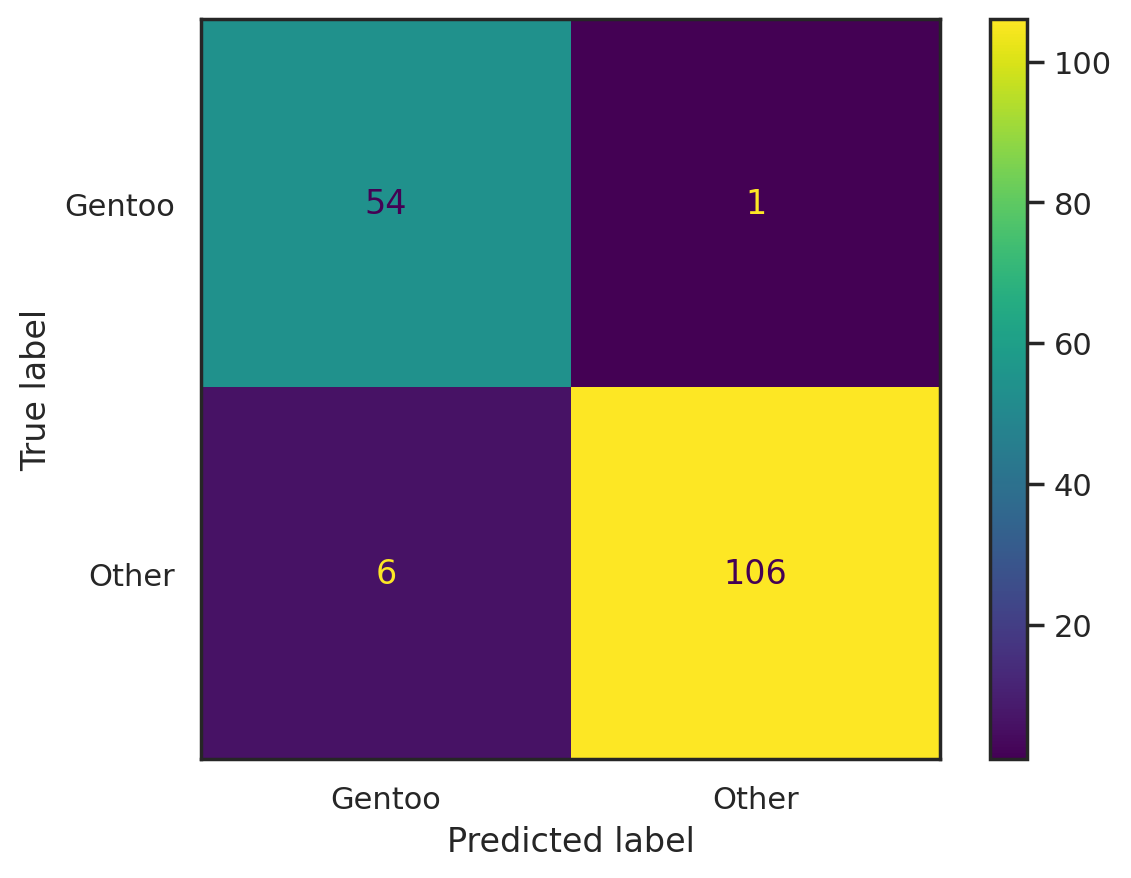

In [12]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# accuracy scores for training and test sets
acc_train = accuracy_score(y_train, yhat_train)
acc_test = accuracy_score(y_test, yhat_test)

print(f'training set accuracy (n={y_train.shape[0]}): {acc_train:4.3f}')
print(f'test set accuracy (n={y_test.shape[0]}): {acc_test:4.3f}')
print()
print('classificiation report on test set performance')
print(classification_report(y_test, yhat_test))
print()

with sns.axes_style('white'):
    ConfusionMatrixDisplay.from_predictions(y_test, yhat_test)

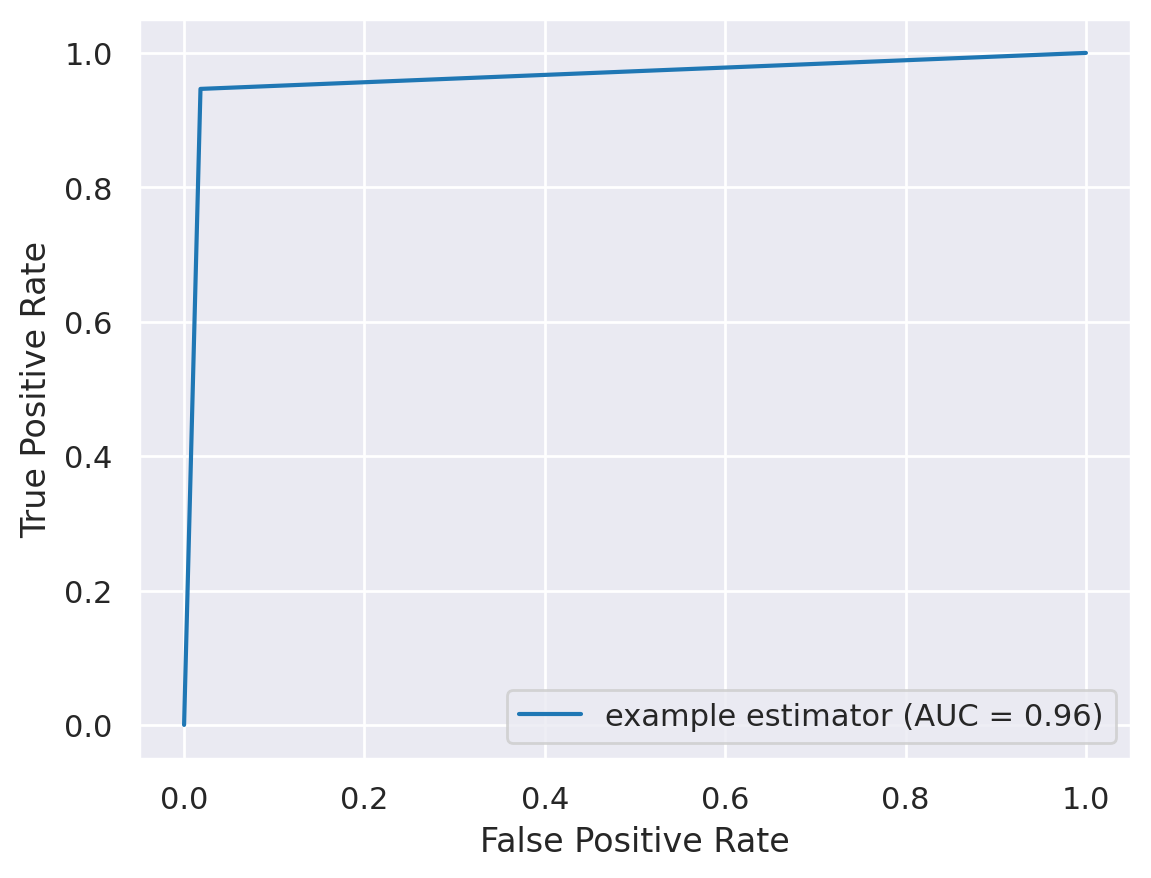

In [14]:
# lets discuss ROC curves now... 
# https://en.wikipedia.org/wiki/Receiver_operating_characteristic
# fundamentally, imagine moving the threshold on LR prediction (f(x) = 1 if logit(x)>threshold else -1) 
# back and forth...  BTW threshold is normally 0.5 
# move towards the positive class.... it will catch more false negatives, and fewer false positives
# towards the negative class... it will catch more false positives, and fewer false negatives
# this what the ROC curve shows us... the inherent tradeoff between two kinds of errors

from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer # some of these helper functions can't handle string labels, need +1/-1

fpr, tpr, thresholds = roc_curve(LabelBinarizer().fit_transform(y_test), 
                                 LabelBinarizer().fit_transform(yhat_test) )
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()
plt.show()

In [15]:
# these are the optimal parameters of logistic regression model
model.coef_, model.intercept_

(array([[-14.28656067]]), array([2957.31798267]))

Let's visualize the loss surface of that logistic regression.  We will take a small grid around the optimal values here and show the loss as a 3d height given the 2d coef + intercept values


In [16]:
from sklearn.metrics import log_loss # this is the logisitc loss function
import numpy as np

dummy_model = LogisticRegression().fit(X_train,y_train)

def loss(coef, intercept):
    dummy_model.coef_ = np.array(coef).reshape((1,1))
    dummy_model.intercept_ = np.array(intercept)
    yhat_train = dummy_model.predict_proba(X_train)
    return log_loss(y_train, yhat_train)

vec_loss = np.vectorize(loss)

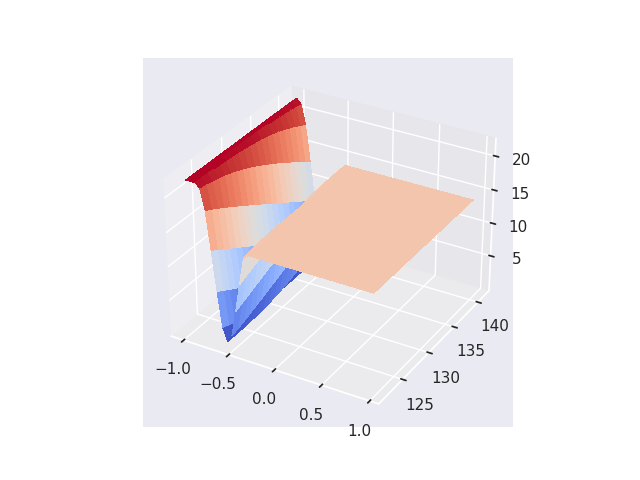

In [17]:
from matplotlib import cm

%matplotlib widget

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
w = np.arange(-1,1,0.05)  # weight coef range around optimal
b = np.arange(122, 142, 1)  # bias intercept range around optimal

X, Y = np.meshgrid(w, b)
Z = vec_loss(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False);

plt.show()

Seems very much like coef is much more important at least in this local area of the params.  Finding the absolute lowest point in that valley might be very hard... the gradients can be vanishingly small so movement towards an optimum requires a fair number of iterations.... or if your solver isn't up to the task it might stop short of optimal

This problem is so simple it hardly will change anything, but in more extreme versions of this it can very much matter what your solver is and its settings as you struggle to follow a weak gradient... like this animation shows on a loss surface kinda like the one above


![weak gradient causes slow gradient descent for many solvers](http://2.bp.blogspot.com/-L98w-SBmF58/VPmICIjKEKI/AAAAAAAACCs/rrFz3VetYmM/s1600/Beale%26amp%3B%23039%3Bs%2Bfunction%2B-%2BImgur.gif![image.png](attachment:image.png))

That's an interesting idea, yeah?  Now go take a look again at the docs for LR https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression and look at the stuff about solver choices.  


Some places to explore:

1. Go back to the start and pick different solvers, see if the choice of solver will change your answers at all
    1. If a solver doesn't work, can you find a set of solver parameters that will fix it?
    1. Are there certain solvers that can't deal with certain penaltys?
1. Try to do all the variables instead of just flipper length. How does that change the answer?
    1. Use scaler() for reals. Like kNN, LR uses a Euclidean distance in the vector space and high magnitude variables will swamp smaller ones in that space.
    1. Use onehot() if you encode sex... you know why
1. Can you use LR to predict all 3 species?  How can that work, when LR is actually at its root a binary classifier????